## Setup

In [1]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
# Replace this with your own root
project_root_dir = 'your_drive_here'

Mounted at /content/drive/


In [3]:
aqi_dir = os.path.join(project_root_dir, 'aqi_data', 'final_data')
experiments_dir = os.path.join(project_root_dir, 'experiments')
img_dir = os.path.join(project_root_dir, 'img_data')

# Simple pixel-level softmax

## Preliminaries
Create test and training sets

In [4]:
# Load our train, validation, and test datasets
train = np.load(os.path.join(experiments_dir, 'train.npz'))
valid = np.load(os.path.join(experiments_dir, 'valid.npz'))
test = np.load(os.path.join(experiments_dir, 'test.npz'))

In [5]:
# Compute the weights that will help with class imbalance
from collections import Counter
item_ct = Counter(train['y'])
max_ct = float(max(item_ct.values()))
class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}

In [6]:
# Center and standardize 
x_mean = train['x'].mean(axis = 0, keepdims = True)
x_std = train['x'].std(axis = 0, keepdims = True) + 1e-7
x_train = (train['x'] - x_mean) / x_std
x_valid = (valid['x'] - x_mean) / x_std

In [7]:
# Flatten the vector 
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_valid_flattened = x_valid.reshape(x_valid.shape[0], -1)

In [8]:
# Since we are limited in RAM in colab, delete the old structure
# and garbage collect
from gc import collect
del x_train, x_valid
collect()

27

In [9]:
# Put the validation and test sets together
x_all = np.concatenate((x_train_flattened, x_valid_flattened))
y_all = np.concatenate((train['y'], valid['y']))

In [10]:
collect()
del x_train_flattened, x_valid_flattened

In [11]:
x_all.shape

(4444, 150528)

## SGD Classifier

### Grid search
Perform a grid search to find the best hyperparameter for the regularization and penalty

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, # try over various values of regularization
              {'l1_ratio' : [0, 0.25, 0.5, 0.75, 1]}] # try different mixtures of L1 and L2 penalty

sgd_clf = SGDClassifier(random_state = 42, class_weight = class_wts, penalty = 'elasticnet')
sgd_clf = GridSearchCV(sgd_clf, param_grid, cv = 3, return_train_score = True)
sgd_clf.fit(x_all, y_all)

## Evaluation

In [17]:
# Standardize the test set
x_test = (test['x'] - x_mean) / x_std
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

In [14]:
x_test_flattened.shape

(1111, 150528)

In [15]:
collect()
del x_test

In [ ]:
# Create a directory to save results 
directory_name = '11-4-20_SGDClf_classWts_elastic_net'
directory_name = os.path.join(experiments_dir, 'model_results', directory_name)
os.mkdir(directory_name)

In [ ]:
x_test = (test['x'] - x_mean) / x_std
x_test_flattened = x_test.reshape(x_valid.shape[0], -1)

test_preds = sgd_clf.predict(x_test_flattened)
test_accuracy = accuracy_score(test['y'], test_preds)
test_accuracy

0.6624662466246625

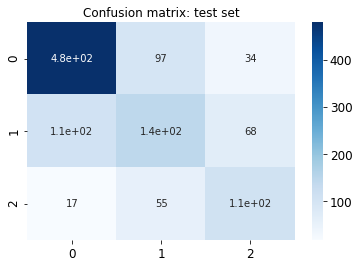

In [19]:
# Visualize confusion matrix
ax = plt.subplot()
test_cf_matrix = confusion_matrix(test['y'], preds)
sns.heatmap(test_cf_matrix, annot = True, ax = ax, cmap = 'Blues')
plt.title('Confusion matrix: test set')
plt.savefig(os.path.join(directory_name, 'test_set_cf_matrix.png'))
plt.show()

In [ ]:
# Save results to our directory
eval_df = pd.DataFrame(columns = ['set', 'loss', 'accuracy'])
eval_df.loc[0] = ['test', 'hinge_loss', test_accuracy]
eval_df.to_csv(os.path.join(directory_name, 'eval_df.csv'))